In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import plotly.express as px


def gapminder(
    df: pd.DataFrame,
    x_col: str | pd.Series,
    y_col: str | pd.Series,
    size_col: str | pd.Series | None = None,
    color_col: str | pd.Series | None = None,
    hover_name: str | None = None,
    title: str = "Gapminder Plot",
    labels: dict | None = None,
) -> None:

    fig = px.scatter(
        df,
        x=x_col,
        y=y_col,
        size=size_col,
        color=color_col,
        hover_name=hover_name,
        title=title,
        labels=labels,
    )
    fig.show()


def parallelplot(
    df: pd.DataFrame,
    columns: list[str | pd.Series],
    color_col: str | pd.Series | None = None,
    title: str = "Parallel Coordinates Plot",
    labels: pd.Series | str | None | dict[str, str] = None,
) -> None:

    fig = px.parallel_coordinates(
        df, dimensions=columns, color=color_col, title=title, labels=labels
    )
    fig.show()

## INTRODUCTION

The dataset that we have here is of the ipl data from 2008 to 2024, We have 3 datasets namely
 - `ball_by_ball` dataset having information for  each  ball for all matches of the ipl 
    - Example : runs scored in that ball, whether that particular ball eas a no ball etc
 - `ipl_summary`  has information about the summary information of a match 
      - Example  location,stadium, winner of the match etc 
 - `match_level_stats` which is derived from the ipl summary with aggregates of ball by ball , contains information for each match that happened in ipl
    - Example : total runs of team 1, who won the toss/match extras per match etc  

The datasets , (all 3 of them) are derived from the json files that we got from cricsheet which is listed under the sports category of the awesome datasets github page 
 - Links:
    - awesome datasets : https://github.com/awesomedata/awesome-public-datasets?tab=readme-ov-file#sports:~:text=Cricsheet%20Matches%20(cricket)
    - cricksheet datasets : https://cricsheet.org/downloads/ then search for ("Indian Premier League") 

In [222]:
ordered_cols = [
    "date",
    "match_number",
    "innings",
    "over",
    "batter",
    "bowler",
    "stage",
    "non_striker",
    "runs.batter",
    "runs.extras",
    "runs.total",
    "extras.legbyes",
    "extras.wides",
    "extras.byes",
    "extras.noballs",
    "wicket.kind",
    "wicket.player_out",
    "wicket.fielders",
    "wickets",
]

### BALL BY BALL DATA


In [223]:
ball_by_ball = pd.read_csv("./output/ipl_ball_by_ball_output_raw.csv")

/tmp/ipykernel_6191/3144535725.py:1: DtypeWarning:

Columns (21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.



In [392]:
ball_by_ball.columns

Index(['date', 'match_number', 'innings', 'over', 'batter', 'bowler', 'stage',
       'non_striker', 'runs.batter', 'runs.extras', 'runs.total',
       'extras.legbyes', 'extras.wides', 'extras.byes', 'extras.noballs',
       'wicket.kind', 'wicket.player_out', 'wicket.fielders', 'season'],
      dtype='object')

We want to ensure that we only have the useful columns as in `ordered_cols`  as,

some times while converting from json format there can be extra excessive columns that may generate confusion!!

Also we want to ensure that we have the rows sorted in terms of date  and match number  in ascending order to make data easily readable.

In [224]:
ball_by_ball = ball_by_ball.reindex(columns=ordered_cols)
ball_by_ball.sort_values(by=["date", "match_number"], inplace=True)

During further analysis of data we might need to group by each season to find season wise statistics and as the `ball_by_ball.date` column  is in **yyyy-mm-dd** format,

we create a new column named `ball_by_ball.season` which contains the season in which the particular match belonged to ,

we get it by slicing the `ball_by_ball.date` to get only the **yyyy** out as the season

In [225]:
ball_by_ball['season'] = ball_by_ball['date'].str.slice(0,4)

In [226]:
ball_by_ball.head()

,date,match_number,innings,over,batter,bowler,stage,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,wickets,season
0,2008-04-18,1,1,0,SC Ganguly,P Kumar,group,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
1,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
3,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008


#### Validation the resultant `ball_by_ball` dataframe


In [228]:
ball_by_ball.columns

Index(['date', 'match_number', 'innings', 'over', 'batter', 'bowler', 'stage',
       'non_striker', 'runs.batter', 'runs.extras', 'runs.total',
       'extras.legbyes', 'extras.wides', 'extras.byes', 'extras.noballs',
       'wicket.kind', 'wicket.player_out', 'wicket.fielders', 'wickets',
       'season'],
      dtype='object')

In [229]:
print("min date: ", ball_by_ball["date"].min())
print("max date: ", ball_by_ball["date"].max())

min date:  2008-04-18
max date:  2024-05-26



Since we have data for IPL matches between 2008 to 2024, the above date range looks right


In [397]:
np.sort(ball_by_ball["match_number"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

The above values for `ball_by_ball.match_number` looks right as there were 76 matches in 2012 season
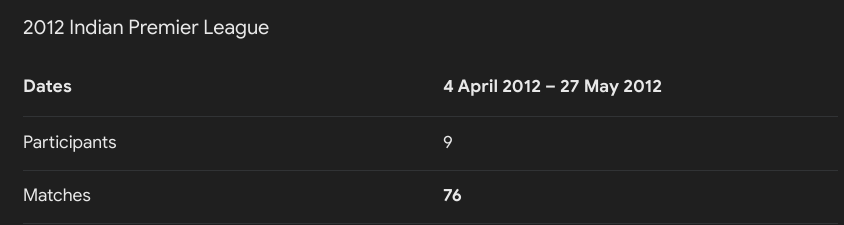

Source : https://www.google.com/search?q=ipl+2012+total+matches

In [231]:
ball_by_ball["innings"].unique()

array([1, 2])

`ball_by_ball.innings` should only have two values as a ipl cricket match has only 2 innings. Hence the above values are right

In [232]:
ball_by_ball["over"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

`ball_by_ball.over` has 20 values of range 0 to 19 which is correct ,An IPL match is of type T20 match  which has 20 overs per inning

In [233]:
sorted(ball_by_ball["runs.batter"].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6)]

A batter can score a maximum of six runs in a ball as shown by the `ball_by_ball.runs.batter` 

In [234]:
sorted(ball_by_ball["runs.extras"].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(7)]

A ball can maximum have riuns of 7 runs that is whwn a no ball is bowled and a six is hit which is again represented in `ball_by_ball.runs.extras`

In [235]:
sorted(ball_by_ball["runs.total"].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7)]

Similar is the case for `ball_by_ball.runs.total` which is the sum of `ball_by_ball.runs.extras` and `ball_by_ball.runs.batter`

We also have the runs given by each tyoe of extras per ball , the sum of which is the `ball_by_ball.runs.extras` column

In [236]:
sorted(ball_by_ball["extras.legbyes"].unique())

[np.float64(1.0),
 np.float64(nan),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0),
 np.float64(5.0)]

In [237]:
sorted(ball_by_ball["extras.wides"].unique())

[np.float64(nan),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0),
 np.float64(5.0)]

In [238]:
sorted(ball_by_ball["extras.byes"].unique())

[np.float64(nan),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0)]

In [239]:
sorted(ball_by_ball["extras.noballs"].unique())

[np.float64(nan),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(5.0)]

Now we can see the different ways in which a wicket can be taken given by `ball_by_ball.wicket.kind` which also clearly looks right 

In [240]:
ball_by_ball["wicket.kind"].unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

the `ball_by_ball.wicket.player_out` column gives the player whos wickert was taken

In [241]:
ball_by_ball["wicket.player_out"].unique()[:10]

array([nan, 'SC Ganguly', 'RT Ponting', 'DJ Hussey', 'R Dravid',
       'V Kohli', 'JH Kallis', 'W Jaffer', 'MV Boucher', 'B Akhil'],
      dtype=object)

the `ball_by_ball.wicket.fielders` is an array of fielders that took the catch as some times more than one player are involved in  a catch  

The below cell shows how many wickwets fell as catches in the entire ipl

In [242]:
ball_by_ball[~pd.isnull(ball_by_ball["wicket.fielders"])]["wicket.fielders"].count()

np.int64(9342)

In the below cell we can see the total number of wickets taken ipl till date

In [243]:
ball_by_ball[~ pd.isnull(ball_by_ball["wickets"])]['wickets'].count()

np.int64(12923)

In [245]:
ball_by_ball

,date,match_number,innings,over,batter,bowler,stage,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,wickets,season
0,2008-04-18,1,1,0,SC Ganguly,P Kumar,group,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
1,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
3,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260754,2024-05-26,73,2,9,SS Iyer,AK Markram,Final,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260755,2024-05-26,73,2,9,VR Iyer,AK Markram,Final,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260756,2024-05-26,73,2,10,VR Iyer,Shahbaz Ahmed,Final,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260757,2024-05-26,73,2,10,SS Iyer,Shahbaz Ahmed,Final,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024


As we can see the `ball_by_ball.wickets` column has a dictionary that contains the `ball_by_ball.wicket.kind` and `ball_by_ball.wicket.fielders` and other wicket related info which have been already represented as their own columns

Hence we can proceed to drop the `ball_by_ball.wickets` column

In [246]:
ball_by_ball.drop(columns='wickets',inplace=True)

In [247]:
ball_by_ball.groupby(['date','match_number','innings','batter']).agg({'runs.batter':np.sum,'runs.extras':np.sum,'bowler':'count'})

/tmp/ipykernel_6191/847661393.py:1: FutureWarning:

The provided callable <function sum at 0x7f5265263920> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

/tmp/ipykernel_6191/847661393.py:1: FutureWarning:

The provided callable <function sum at 0x7f5265263920> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



runs.batter  runs.extras  \
date       match_number innings batter                                         
2008-04-18 1            1       BB McCullum                 158           11   
                                DJ Hussey                    12            0   
                                Mohammad Hafeez               5            0   
                                RT Ponting                   20            4   
                                SC Ganguly                   10            2   
...                                                         ...          ...   
2024-05-26 73           1       TM Head                       0            0   
                        2       Rahmanullah Gurbaz           39            7   
                                SP Narine                     6            0   
                                SS Iyer                       6            0   
                                VR Iyer                      52            4   

                                                    bowler  
date       match_number innings batter                      
2008-04-18 1            1       BB McCullum             77  
                                DJ Hussey               12  
                                Mohammad Hafeez          3  
                                RT Ponting              20  
                                SC Ganguly              12  
...                                                    ...  
2024-05-26 73           1       TM Head                  1  
                        2       Rahmanullah Gurbaz      35  
                                SP Narine                2  
                                SS Iyer                  3  
                                VR Iyer                 27  

[16515 rows x 3 columns]

In [248]:
ball_by_ball.groupby(['date','match_number','innings','bowler','runs.batter']).agg({'runs.total':'sum','wicket.kind':'count','batter':'count'})

runs.total  \
date       match_number innings bowler        runs.batter               
2008-04-18 1            1       AA Noffke     0                     6   
                                              1                    11   
                                              2                     4   
                                              4                     8   
                                              6                    12   
...                                                               ...   
2024-05-26 73           2       Shahbaz Ahmed 6                    12   
                                T Natarajan   0                     2   
                                              1                     5   
                                              4                    16   
                                              6                     6   

                                                           wicket.kind  batter  
date       match_number innings bowler        runs.batter                       
2008-04-18 1            1       AA Noffke     0                      1       8  
                                              1                      0      11  
                                              2                      0       2  
                                              4                      0       2  
                                              6                      0       2  
...                                                                ...     ...  
2024-05-26 73           2       Shahbaz Ahmed 6                      0       2  
                                T Natarajan   0                      0       4  
                                              1                      0       5  
                                              4                      0       4  
                                              6                      0       1  

[54044 rows x 3 columns]

In [249]:
ball_by_ball.to_csv("output/ipl_ball_by_ball_output.csv", index=False)

### THE SUMMARY DATA

In [250]:
ipl_summary = pd.read_csv('output/ipl_summary_raw.csv')

In [251]:
ipl_summary.head()

,info_balls_per_over,info_city,info_dates_1,info_event_match_number,info_event_name,info_gender,info_match_type,info_officials_match_referees_1,info_officials_reserve_umpires_1,info_officials_tv_umpires_1,info_officials_umpires_1,info_officials_umpires_2,info_outcome_by_runs,info_outcome_winner,info_overs,info_player_of_match_1,info_season,info_team_type,info_teams_1,info_teams_2,info_toss_decision,info_toss_winner,info_venue,info_outcome_by_wickets,info_outcome_eliminator,info_outcome_result,info_event_stage,info_dates_2,info_outcome_method
0,6,Hyderabad,2017-04-05,1.0,Indian Premier League,male,T20,J Srinath,N Pandit,A Deshmukh,AY Dandekar,NJ Llong,35.0,Sunrisers Hyderabad,20,Yuvraj Singh,2017,club,Sunrisers Hyderabad,Royal Challengers Bangalore,field,Royal Challengers Bangalore,"Rajiv Gandhi International Stadium, Uppal",NaN,NaN,NaN,NaN,NaN,NaN
1,6,Pune,2017-04-06,2.0,Indian Premier League,male,T20,M Nayyar,Navdeep Singh,VK Sharma,A Nand Kishore,S Ravi,NaN,Rising Pune Supergiant,20,SPD Smith,2017,club,Rising Pune Supergiant,Mumbai Indians,field,Rising Pune Supergiant,Maharashtra Cricket Association Stadium,7.0,NaN,NaN,NaN,NaN,NaN
2,6,Rajkot,2017-04-07,3.0,Indian Premier League,male,T20,V Narayan Kutty,K Srinivasan,YC Barde,Nitin Menon,CK Nandan,NaN,Kolkata Knight Riders,20,CA Lynn,2017,club,Gujarat Lions,Kolkata Knight Riders,field,Kolkata Knight Riders,Saurashtra Cricket Association Stadium,10.0,NaN,NaN,NaN,NaN,NaN
3,6,Indore,2017-04-08,4.0,Indian Premier League,male,T20,Chinmay Sharma,R Pandit,KN Ananthapadmanabhan,AK Chaudhary,C Shamshuddin,NaN,Kings XI Punjab,20,GJ Maxwell,2017,club,Kings XI Punjab,Rising Pune Supergiant,field,Kings XI Punjab,Holkar Cricket Stadium,6.0,NaN,NaN,NaN,NaN,NaN
4,6,Bengaluru,2017-04-08,5.0,Indian Premier League,male,T20,J Srinath,Navdeep Singh,A Nand Kishore,S Ravi,VK Sharma,15.0,Royal Challengers Bangalore,20,KM Jadhav,2017,club,Royal Challengers Bangalore,Delhi Daredevils,bat,Royal Challengers Bangalore,M.Chinnaswamy Stadium,NaN,NaN,NaN,NaN,NaN,NaN


In [252]:
def remove_prefix(x: str, to_replace: str, replace_by: str):
    return x.replace(to_replace, replace_by)

In [253]:
ipl_summary.rename(
    lambda x: remove_prefix(str(x), to_replace="info_", replace_by=""),
    inplace=True,
    axis=1,
)

In [254]:
ipl_summary.rename(
    lambda x: remove_prefix(str(x), to_replace=" ", replace_by="_"),
    inplace=True,
    axis=1,
)

In [255]:
ipl_summary.rename(lambda x: str(x).lower(), inplace=True, axis=1)

In [256]:
ipl_summary.head()

,balls_per_over,city,dates_1,event_match_number,event_name,gender,match_type,officials_match_referees_1,officials_reserve_umpires_1,officials_tv_umpires_1,officials_umpires_1,officials_umpires_2,outcome_by_runs,outcome_winner,overs,player_of_match_1,season,team_type,teams_1,teams_2,toss_decision,toss_winner,venue,outcome_by_wickets,outcome_eliminator,outcome_result,event_stage,dates_2,outcome_method
0,6,Hyderabad,2017-04-05,1.0,Indian Premier League,male,T20,J Srinath,N Pandit,A Deshmukh,AY Dandekar,NJ Llong,35.0,Sunrisers Hyderabad,20,Yuvraj Singh,2017,club,Sunrisers Hyderabad,Royal Challengers Bangalore,field,Royal Challengers Bangalore,"Rajiv Gandhi International Stadium, Uppal",NaN,NaN,NaN,NaN,NaN,NaN
1,6,Pune,2017-04-06,2.0,Indian Premier League,male,T20,M Nayyar,Navdeep Singh,VK Sharma,A Nand Kishore,S Ravi,NaN,Rising Pune Supergiant,20,SPD Smith,2017,club,Rising Pune Supergiant,Mumbai Indians,field,Rising Pune Supergiant,Maharashtra Cricket Association Stadium,7.0,NaN,NaN,NaN,NaN,NaN
2,6,Rajkot,2017-04-07,3.0,Indian Premier League,male,T20,V Narayan Kutty,K Srinivasan,YC Barde,Nitin Menon,CK Nandan,NaN,Kolkata Knight Riders,20,CA Lynn,2017,club,Gujarat Lions,Kolkata Knight Riders,field,Kolkata Knight Riders,Saurashtra Cricket Association Stadium,10.0,NaN,NaN,NaN,NaN,NaN
3,6,Indore,2017-04-08,4.0,Indian Premier League,male,T20,Chinmay Sharma,R Pandit,KN Ananthapadmanabhan,AK Chaudhary,C Shamshuddin,NaN,Kings XI Punjab,20,GJ Maxwell,2017,club,Kings XI Punjab,Rising Pune Supergiant,field,Kings XI Punjab,Holkar Cricket Stadium,6.0,NaN,NaN,NaN,NaN,NaN
4,6,Bengaluru,2017-04-08,5.0,Indian Premier League,male,T20,J Srinath,Navdeep Singh,A Nand Kishore,S Ravi,VK Sharma,15.0,Royal Challengers Bangalore,20,KM Jadhav,2017,club,Royal Challengers Bangalore,Delhi Daredevils,bat,Royal Challengers Bangalore,M.Chinnaswamy Stadium,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
def populate_team_1(row):
    toss_winner = row["toss_winner"]
    if row["toss_decision"] == "bat":
        team_1 = row["toss_winner"]
    else:
        teams_1 = row["teams_1"]
        teams_2 = row["teams_2"]
        team_1 = teams_2 if toss_winner == teams_1 else teams_1

    return team_1

In [258]:
ipl_summary["team_1"] = ipl_summary.apply(populate_team_1, axis=1)

In [259]:
def populate_team_2(row):
    toss_winner = row["toss_winner"]
    if row["toss_decision"] == "field":
        team_2 = row["toss_winner"]
    else:
        teams_1 = row["teams_1"]
        teams_2 = row["teams_2"]
        team_2 = teams_2 if toss_winner == teams_1 else teams_1

    return team_2

In [260]:
ipl_summary["team_2"] = ipl_summary.apply(populate_team_2, axis=1)

In [261]:
ipl_summary.columns

Index(['balls_per_over', 'city', 'dates_1', 'event_match_number', 'event_name',
       'gender', 'match_type', 'officials_match_referees_1',
       'officials_reserve_umpires_1', 'officials_tv_umpires_1',
       'officials_umpires_1', 'officials_umpires_2', 'outcome_by_runs',
       'outcome_winner', 'overs', 'player_of_match_1', 'season', 'team_type',
       'teams_1', 'teams_2', 'toss_decision', 'toss_winner', 'venue',
       'outcome_by_wickets', 'outcome_eliminator', 'outcome_result',
       'event_stage', 'dates_2', 'outcome_method', 'team_1', 'team_2'],
      dtype='object')

In [262]:
sel_cols = [
    "teams_1",
    "teams_2",
    "toss_decision",
    "toss_winner",
    "outcome_winner",
    "team_1",
    "team_2",
]
ipl_summary[sel_cols].head()

,teams_1,teams_2,toss_decision,toss_winner,outcome_winner,team_1,team_2
0,Sunrisers Hyderabad,Royal Challengers Bangalore,field,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore
1,Rising Pune Supergiant,Mumbai Indians,field,Rising Pune Supergiant,Rising Pune Supergiant,Mumbai Indians,Rising Pune Supergiant
2,Gujarat Lions,Kolkata Knight Riders,field,Kolkata Knight Riders,Kolkata Knight Riders,Gujarat Lions,Kolkata Knight Riders
3,Kings XI Punjab,Rising Pune Supergiant,field,Kings XI Punjab,Kings XI Punjab,Rising Pune Supergiant,Kings XI Punjab
4,Royal Challengers Bangalore,Delhi Daredevils,bat,Royal Challengers Bangalore,Royal Challengers Bangalore,Royal Challengers Bangalore,Delhi Daredevils


In [263]:
ipl_summary.drop(columns=["teams_1", "teams_2"], inplace=True)

### Following columns have only a single value and so can be dropped from the dataframe

1. balls_per_over
2. event_name
3. gender
4. match_type
5. overs
6. team_type


In [264]:
ipl_summary["balls_per_over"].value_counts()

balls_per_over
6    1095
Name: count, dtype: int64

In [265]:
ipl_summary["event_name"].value_counts()

event_name
Indian Premier League    1095
Name: count, dtype: int64

In [266]:
ipl_summary["gender"].value_counts()

gender
male    1095
Name: count, dtype: int64

In [267]:
ipl_summary["match_type"].value_counts()

match_type
T20    1095
Name: count, dtype: int64

In [268]:
ipl_summary["overs"].value_counts()

overs
20    1095
Name: count, dtype: int64

In [269]:
ipl_summary["team_type"].value_counts()

team_type
club    1095
Name: count, dtype: int64

In [270]:
ipl_summary.drop(
    columns=[
        "balls_per_over",
        "event_name",
        "gender",
        "match_type",
        "overs",
        "team_type",
    ],
    inplace=True,
)

### Season has 2016 represented as string and numeric and so it is showing up as two different values. Convert to str type


In [271]:
ipl_summary[ipl_summary["season"].apply(lambda x: str(x).strip().find("2016") != -1)][
    "season"
].value_counts()

season
2016    60
Name: count, dtype: int64

In [272]:
ipl_summary["season"] = ipl_summary["season"].astype(str)

In [273]:
ipl_summary.season.value_counts()

season
2013       76
2012       74
2023       74
2022       74
2011       73
2024       71
2016       60
2021       60
2018       60
2014       60
2019       60
2020/21    60
2009/10    60
2017       59
2015       59
2007/08    58
2009       57
Name: count, dtype: int64

In [274]:
ipl_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         1044 non-null   object 
 1   dates_1                      1095 non-null   object 
 2   event_match_number           1029 non-null   float64
 3   officials_match_referees_1   1095 non-null   object 
 4   officials_reserve_umpires_1  1071 non-null   object 
 5   officials_tv_umpires_1       1091 non-null   object 
 6   officials_umpires_1          1095 non-null   object 
 7   officials_umpires_2          1095 non-null   object 
 8   outcome_by_runs              498 non-null    float64
 9   outcome_winner               1076 non-null   object 
 10  player_of_match_1            1090 non-null   object 
 11  season                       1095 non-null   object 
 12  toss_decision                1095 non-null   object 
 13  toss_winner       

In [275]:
ipl_summary.loc[ipl_summary["event_match_number"].isnull(), "event_match_number"] = -1

In [276]:
ipl_summary["event_match_number"] = ipl_summary["event_match_number"].astype(int)

In [277]:
ipl_summary["event_match_number"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 25, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, -1, 29, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

In [278]:
ipl_summary.describe()

,event_match_number,outcome_by_runs,outcome_by_wickets
count,1095.000000,498.000000,578.000000
mean,29.479452,30.104418,6.192042
std,19.388911,26.739844,1.845733
min,-1.000000,1.000000,1.000000
25%,13.000000,11.000000,5.000000
50%,29.000000,22.000000,6.000000
75%,45.000000,41.000000,7.000000
max,72.000000,146.000000,10.000000


In [279]:
for col in ipl_summary.columns:
    print(col, ipl_summary[col].dtype, sep=" => ")

city => object
dates_1 => object
event_match_number => int64
officials_match_referees_1 => object
officials_reserve_umpires_1 => object
officials_tv_umpires_1 => object
officials_umpires_1 => object
officials_umpires_2 => object
outcome_by_runs => float64
outcome_winner => object
player_of_match_1 => object
season => object
toss_decision => object
toss_winner => object
venue => object
outcome_by_wickets => float64
outcome_eliminator => object
outcome_result => object
event_stage => object
dates_2 => object
outcome_method => object
team_1 => object
team_2 => object


# Handle Missing Values


In [280]:
# populate missing city values based on the stadium
ipl_summary.loc[ipl_summary["venue"] == "Sharjah Cricket Stadium", "city"] = "Sharjah"
ipl_summary.loc[ipl_summary["venue"] == "Dubai International Cricket Stadium", "city"] = "Dubai"

In [281]:
# Drop dates_2 and outcome_eliminator columns as it has 98% missing values
ipl_summary = ipl_summary.drop(columns=["dates_2", "outcome_eliminator"])

In [282]:
# Defaulting the event_stage to group_stage as it is left blank
ipl_summary.loc[ipl_summary["event_stage"].isnull(), "event_stage"] = "group_stage"

In [283]:
ipl_summary['outcome_result']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1090    NaN
1091    NaN
1092    NaN
1093    NaN
1094    NaN
Name: outcome_result, Length: 1095, dtype: object

In [284]:
ipl_summary.loc[ipl_summary["outcome_winner"].isnull(), "outcome_winner"] = ipl_summary["outcome_result"]

In [285]:
ipl_summary.loc[ipl_summary["outcome_method"].isnull(), "outcome_method"] = "regular"

In [286]:
# drop outcome_result as it is merged in the outcome_winner column
ipl_summary.drop(columns=["outcome_result"], inplace=True)

In [287]:
# Fix season values
ipl_summary.loc[ipl_summary["season"] == "2007/08", "season"] = "2008"
ipl_summary.loc[ipl_summary["season"] == "2009/10", "season"] = "2010"
ipl_summary.loc[ipl_summary["season"] == "2020/21", "season"] = "2020"

In [288]:
ipl_summary["season"].value_counts().sort_index()

season
2008    58
2009    57
2010    60
2011    73
2012    74
2013    76
2014    60
2015    59
2016    60
2017    59
2018    60
2019    60
2020    60
2021    60
2022    74
2023    74
2024    71
Name: count, dtype: int64

In [289]:
ipl_summary["season"] = ipl_summary["season"].astype(int)

In [290]:
# Handle event_match_number
print(len(ipl_summary.loc[ipl_summary["event_match_number"] == -1, "event_match_number"]))
ipl_summary.loc[ipl_summary["event_match_number"] == -1, ["season", "dates_1"]].sort_values(by="dates_1")

66


,season,dates_1
573,2008,2008-05-30
574,2008,2008-05-31
575,2008,2008-06-01
630,2009,2009-05-22
631,2009,2009-05-23
...,...,...
446,2023,2023-05-29
514,2024,2024-05-21
515,2024,2024-05-22
516,2024,2024-05-24


In [291]:
# Not using this as we are populating the missing match numbers with event stage
def populate_match_numbers(df, season):
    df_part = df.loc[
        (df["season"] == season) & (df["event_match_number"].isnull()),
        ["event_match_number", "dates_1"],
    ].sort_values(by="dates_1")
    max_match_number = df[df["season"] == season]["event_match_number"].max() + 1
    print(df_part)
    for index, _ in df_part.iterrows():
        df.loc[index, "event_match_number"] = max_match_number
        max_match_number += 1

    print(df)

In [292]:
# Not using this as we are populating the missing match numbers with event stage
def populate_match_numbers_across_seasons(df):
    for seas in df.season.unique():
        populate_match_numbers(df, seas)

In [293]:
# Not using this as we are populating the missing match numbers with event stage
# populate_match_numbers_across_seasons(df)

In [294]:
# note that this would convert the null values to string "nan"
ipl_summary["event_match_number"] = ipl_summary["event_match_number"].astype(str)

In [295]:
ipl_summary.sort_values(by='dates_1',inplace=True)

In [296]:
ipl_summary.loc[ipl_summary["event_match_number"] == "-1", ["event_match_number"]] = ipl_summary["event_stage"]

In [297]:
ipl_summary['match_number'] = 0

In [298]:
prev_match_number = -1
for match_number,season in zip(ipl_summary['event_match_number'],ipl_summary['season']):

    if match_number.isnumeric():
        ipl_summary.loc[(ipl_summary["event_match_number"] == match_number) &(ipl_summary['season'] == season) , ["match_number"]] = int(
            match_number
        )
    else:
        int_match_number= prev_match_number+1
        ipl_summary.loc[
            (ipl_summary["event_match_number"] == match_number) & (ipl_summary["season"] == season),
            ["match_number"],
        ] = int_match_number
        match_number = int_match_number
    prev_match_number = int(match_number)

In [299]:
ipl_summary['match_number'].value_counts()

match_number
58    20
56    18
1     17
2     17
4     17
      ..
63     5
66     5
74     4
75     2
76     1
Name: count, Length: 76, dtype: int64

In [300]:
ipl_summary["match_number"].unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 12, 11, 14, 13, 15, 16, 17,
       19, 18, 20, 22, 21, 23, 24, 25, 26, 27, 29, 28, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 42, 41, 43, 44, 45, 46, 48, 50, 49, 51, 52,
       53, 54, 55, 56, 58, 59, 47, 60, 57, 61, 62, 63, 64, 65, 66, 67, 68,
       70, 69, 71, 72, 73, 74, 75, 76])

In [301]:
pd.Series(ipl_summary["venue"].unique())

0                                 M Chinnaswamy Stadium
1            Punjab Cricket Association Stadium, Mohali
2                                      Feroz Shah Kotla
3                                      Wankhede Stadium
4                                          Eden Gardens
5                                Sawai Mansingh Stadium
6             Rajiv Gandhi International Stadium, Uppal
7                       MA Chidambaram Stadium, Chepauk
8                            Dr DY Patil Sports Academy
9                                              Newlands
10                                     St George's Park
11                                            Kingsmead
12                                      SuperSport Park
13                                         Buffalo Park
14                                New Wanderers Stadium
15                                De Beers Diamond Oval
16                                      OUTsurance Oval
17                                    Brabourne 

In [302]:
ipl_summary["venue"] = ipl_summary["venue"].str.partition(",")[0]

In [303]:
ipl_summary["venue"] = ipl_summary["venue"].str.replace(".", "")

In [304]:
ipl_summary["venue"] = ipl_summary["venue"].str.replace(" ", "")

In [305]:
pd.Series(ipl_summary["venue"].unique())

0                                   MChinnaswamyStadium
1                       PunjabCricketAssociationStadium
2                                        FerozShahKotla
3                                       WankhedeStadium
4                                           EdenGardens
5                                  SawaiMansinghStadium
6                       RajivGandhiInternationalStadium
7                                  MAChidambaramStadium
8                                DrDYPatilSportsAcademy
9                                              Newlands
10                                       StGeorge'sPark
11                                            Kingsmead
12                                       SuperSportPark
13                                          BuffaloPark
14                                  NewWanderersStadium
15                                   DeBeersDiamondOval
16                                       OUTsuranceOval
17                                     Brabourne

In [306]:
ipl_summary.columns

Index(['city', 'dates_1', 'event_match_number', 'officials_match_referees_1',
       'officials_reserve_umpires_1', 'officials_tv_umpires_1',
       'officials_umpires_1', 'officials_umpires_2', 'outcome_by_runs',
       'outcome_winner', 'player_of_match_1', 'season', 'toss_decision',
       'toss_winner', 'venue', 'outcome_by_wickets', 'event_stage',
       'outcome_method', 'team_1', 'team_2', 'match_number'],
      dtype='object')

In [307]:
ipl_summary = ipl_summary.rename(
    columns={
        "dates_1": "date",
        "officials_match_referees_1": "officials_match_referees",
        "officials_reserve_umpires_1": "officials_reserve_umpires",
        "officials_tv_umpires_1": "officials_tv_umpires",
        "teams_1": "team_1",
        "teams_2": "team_2",
        "player_of_match_1": "player_of_match",
    }
)

In [308]:
ipl_summary.columns

Index(['city', 'date', 'event_match_number', 'officials_match_referees',
       'officials_reserve_umpires', 'officials_tv_umpires',
       'officials_umpires_1', 'officials_umpires_2', 'outcome_by_runs',
       'outcome_winner', 'player_of_match', 'season', 'toss_decision',
       'toss_winner', 'venue', 'outcome_by_wickets', 'event_stage',
       'outcome_method', 'team_1', 'team_2', 'match_number'],
      dtype='object')

In [309]:
ipl_summary.rename(columns={"event_match_number": "season_match_no"}, inplace=True)

In [310]:
cols = [
    "date",
    "match_number",
    "city",
    "team_1",
    "team_2",
    "season_match_no",
    "outcome_winner",
    "player_of_match",
    "toss_winner",
    "toss_decision",
    "officials_match_referees",
    "officials_reserve_umpires",
    "officials_tv_umpires",
    "officials_umpires_1",
    "officials_umpires_2",
    "outcome_by_wickets",
    "season",
    "venue",
    "outcome_by_runs",
    "event_stage",
    "outcome_method",
]
ipl_summary = ipl_summary.reindex(columns=cols)

In [311]:
ipl_summary = ipl_summary.sort_values(by=["date", "match_number"])

In [312]:
ipl_summary["season"] = ipl_summary["date"].str.slice(0, 4)

In [313]:
ipl_summary.season.value_counts()

season
2013    76
2022    74
2012    74
2023    74
2011    73
2024    71
2019    60
2016    60
2010    60
2021    60
2020    60
2014    60
2018    60
2017    59
2015    59
2008    58
2009    57
Name: count, dtype: int64

In [314]:
ipl_summary.to_csv("output/ipl_summary.csv", index=False)

In [315]:
ball_by_ball 

,date,match_number,innings,over,batter,bowler,stage,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,season
0,2008-04-18,1,1,0,SC Ganguly,P Kumar,group,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
1,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2008
3,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260754,2024-05-26,73,2,9,SS Iyer,AK Markram,Final,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260755,2024-05-26,73,2,9,VR Iyer,AK Markram,Final,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260756,2024-05-26,73,2,10,VR Iyer,Shahbaz Ahmed,Final,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260757,2024-05-26,73,2,10,SS Iyer,Shahbaz Ahmed,Final,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024


In [316]:
ball_by_ball.shape

(260759, 19)

In [317]:
ball_by_ball.head()

,date,match_number,innings,over,batter,bowler,stage,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,season
0,2008-04-18,1,1,0,SC Ganguly,P Kumar,group,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
1,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2008
3,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008


In [318]:
ipl_summary["match_number"] = ipl_summary["match_number"].astype("str")

In [319]:
ipl_summary.shape

(1095, 21)

In [320]:
ipl_summary.head()

,date,match_number,city,team_1,team_2,season_match_no,outcome_winner,player_of_match,toss_winner,toss_decision,officials_match_referees,officials_reserve_umpires,officials_tv_umpires,officials_umpires_1,officials_umpires_2,outcome_by_wickets,season,venue,outcome_by_runs,event_stage,outcome_method
518,2008-04-18,1,Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,1,Kolkata Knight Riders,BB McCullum,Royal Challengers Bangalore,field,J Srinath,VN Kulkarni,AM Saheba,Asad Rauf,RE Koertzen,NaN,2008,MChinnaswamyStadium,140.0,group_stage,regular
519,2008-04-19,2,Chandigarh,Chennai Super Kings,Kings XI Punjab,2,Chennai Super Kings,MEK Hussey,Chennai Super Kings,bat,S Venkataraghavan,MSS Ranawat,RB Tiffin,MR Benson,SL Shastri,NaN,2008,PunjabCricketAssociationStadium,33.0,group_stage,regular
520,2008-04-19,3,Delhi,Rajasthan Royals,Delhi Daredevils,3,Delhi Daredevils,MF Maharoof,Rajasthan Royals,bat,GR Viswanath,NaN,IL Howell,Aleem Dar,GA Pratapkumar,9.0,2008,FerozShahKotla,NaN,group_stage,regular
522,2008-04-20,4,Kolkata,Deccan Chargers,Kolkata Knight Riders,4,Kolkata Knight Riders,DJ Hussey,Deccan Chargers,bat,FM Engineer,F Gomes,Asad Rauf,BF Bowden,K Hariharan,5.0,2008,EdenGardens,NaN,group_stage,regular
521,2008-04-20,5,Mumbai,Mumbai Indians,Royal Challengers Bangalore,5,Royal Challengers Bangalore,MV Boucher,Mumbai Indians,bat,J Srinath,SN Bandekar,AV Jayaprakash,SJ Davis,DJ Harper,5.0,2008,WankhedeStadium,NaN,group_stage,regular


In [321]:
def get_items_by_team(field, agg="sum"):
    if agg == "sum":
        grouped_df = ball_by_ball.groupby(["date", "match_number", "innings"])[field].sum()
    elif agg == "max":
        grouped_df = ball_by_ball.groupby(["date", "match_number", "innings"])[field].max()

    grouped_df = grouped_df.reset_index()

    df_pivot = grouped_df.pivot(
        index=["date", "match_number"], columns="innings", values=field
    )

    df_pivot.reset_index(inplace=True)

    df_pivot = df_pivot.rename(columns={1: "team_1_" + field, 2: "team_2_" + field})

    return df_pivot

In [322]:
match_level_col = get_items_by_team("runs.total")

In [323]:
match_level_col.match_number.dtype

dtype('int64')

In [324]:
ipl_summary['match_number'] = ipl_summary.match_number.astype(int)

In [325]:
match_level_stats = pd.merge(ipl_summary, match_level_col, how="outer", on=["date", "match_number"])

In [326]:
match_level_col = get_items_by_team("runs.extras")
match_level_stats = pd.merge(match_level_stats, match_level_col, how="outer", on=["date", "match_number"])

In [327]:
match_level_col = get_items_by_team("extras.legbyes")
match_level_stats = pd.merge(match_level_stats, match_level_col, how="outer", on=["date", "match_number"])

In [328]:
match_level_col = get_items_by_team("extras.wides")
match_level_stats = pd.merge(match_level_stats, match_level_col, how="outer", on=["date", "match_number"])

In [329]:
match_level_col = get_items_by_team("extras.byes")
match_level_stats = pd.merge(match_level_stats, match_level_col, how="outer", on=["date", "match_number"])

In [330]:
match_level_col = get_items_by_team("extras.noballs")
match_level_stats = pd.merge(match_level_stats, match_level_col, how="outer", on=["date", "match_number"])

In [331]:
match_level_col = get_items_by_team("over", "max")
match_level_stats = pd.merge(match_level_stats, match_level_col, how="outer", on=["date", "match_number"])

In [332]:
pd.set_option("display.max_columns", 35)
match_level_stats.head()

,date,match_number,city,team_1,team_2,season_match_no,outcome_winner,player_of_match,toss_winner,toss_decision,officials_match_referees,officials_reserve_umpires,officials_tv_umpires,officials_umpires_1,officials_umpires_2,outcome_by_wickets,season,venue,outcome_by_runs,event_stage,outcome_method,team_1_runs.total,team_2_runs.total,team_1_runs.extras,team_2_runs.extras,team_1_extras.legbyes,team_2_extras.legbyes,team_1_extras.wides,team_2_extras.wides,team_1_extras.byes,team_2_extras.byes,team_1_extras.noballs,team_2_extras.noballs,team_1_over,team_2_over
0,2008-04-18,1,Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,1,Kolkata Knight Riders,BB McCullum,Royal Challengers Bangalore,field,J Srinath,VN Kulkarni,AM Saheba,Asad Rauf,RE Koertzen,NaN,2008,MChinnaswamyStadium,140.0,group_stage,regular,222.0,82.0,17.0,19.0,4.0,8.0,9.0,11.0,4.0,0.0,0.0,0.0,19.0,15.0
1,2008-04-19,2,Chandigarh,Chennai Super Kings,Kings XI Punjab,2,Chennai Super Kings,MEK Hussey,Chennai Super Kings,bat,S Venkataraghavan,MSS Ranawat,RB Tiffin,MR Benson,SL Shastri,NaN,2008,PunjabCricketAssociationStadium,33.0,group_stage,regular,240.0,207.0,6.0,11.0,2.0,4.0,3.0,5.0,0.0,2.0,1.0,0.0,19.0,19.0
2,2008-04-19,3,Delhi,Rajasthan Royals,Delhi Daredevils,3,Delhi Daredevils,MF Maharoof,Rajasthan Royals,bat,GR Viswanath,NaN,IL Howell,Aleem Dar,GA Pratapkumar,9.0,2008,FerozShahKotla,NaN,group_stage,regular,129.0,132.0,7.0,10.0,3.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,19.0,15.0
3,2008-04-20,4,Kolkata,Deccan Chargers,Kolkata Knight Riders,4,Kolkata Knight Riders,DJ Hussey,Deccan Chargers,bat,FM Engineer,F Gomes,Asad Rauf,BF Bowden,K Hariharan,5.0,2008,EdenGardens,NaN,group_stage,regular,110.0,112.0,10.0,28.0,4.0,8.0,4.0,15.0,0.0,4.0,2.0,1.0,18.0,18.0
4,2008-04-20,5,Mumbai,Mumbai Indians,Royal Challengers Bangalore,5,Royal Challengers Bangalore,MV Boucher,Mumbai Indians,bat,J Srinath,SN Bandekar,AV Jayaprakash,SJ Davis,DJ Harper,5.0,2008,WankhedeStadium,NaN,group_stage,regular,165.0,166.0,11.0,5.0,6.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,19.0,19.0


In [333]:
cols = [
    "date",
    "match_number",
    "city",
    "team_1",
    "team_2",
    "team_1_runs.total",
    "team_2_runs.total",
    "outcome_winner",
    "player_of_match",
    "team_1_over",
    "team_2_over",
    "toss_winner",
    "toss_decision",
    "team_1_runs.extras",
    "team_2_runs.extras",
    "team_1_extras.legbyes",
    "team_2_extras.legbyes",
    "team_1_extras.wides",
    "team_2_extras.wides",
    "team_1_extras.byes",
    "team_2_extras.byes",
    "team_1_extras.noballs",
    "team_2_extras.noballs",
    "officials_match_referees",
    "officials_reserve_umpires",
    "officials_tv_umpires",
    "officials_umpires_1",
    "officials_umpires_2",
    "outcome_by_wickets",
    "season",
    "venue",
    "outcome_by_runs",
    "event_stage",
    "outcome_method",
]
match_level_stats = match_level_stats.reindex(columns=cols)

In [334]:
pd.set_option('display.max_columns', 40)

match_level_stats.head()

,date,match_number,city,team_1,team_2,team_1_runs.total,team_2_runs.total,outcome_winner,player_of_match,team_1_over,team_2_over,toss_winner,toss_decision,team_1_runs.extras,team_2_runs.extras,team_1_extras.legbyes,team_2_extras.legbyes,team_1_extras.wides,team_2_extras.wides,team_1_extras.byes,team_2_extras.byes,team_1_extras.noballs,team_2_extras.noballs,officials_match_referees,officials_reserve_umpires,officials_tv_umpires,officials_umpires_1,officials_umpires_2,outcome_by_wickets,season,venue,outcome_by_runs,event_stage,outcome_method
0,2008-04-18,1,Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,222.0,82.0,Kolkata Knight Riders,BB McCullum,19.0,15.0,Royal Challengers Bangalore,field,17.0,19.0,4.0,8.0,9.0,11.0,4.0,0.0,0.0,0.0,J Srinath,VN Kulkarni,AM Saheba,Asad Rauf,RE Koertzen,NaN,2008,MChinnaswamyStadium,140.0,group_stage,regular
1,2008-04-19,2,Chandigarh,Chennai Super Kings,Kings XI Punjab,240.0,207.0,Chennai Super Kings,MEK Hussey,19.0,19.0,Chennai Super Kings,bat,6.0,11.0,2.0,4.0,3.0,5.0,0.0,2.0,1.0,0.0,S Venkataraghavan,MSS Ranawat,RB Tiffin,MR Benson,SL Shastri,NaN,2008,PunjabCricketAssociationStadium,33.0,group_stage,regular
2,2008-04-19,3,Delhi,Rajasthan Royals,Delhi Daredevils,129.0,132.0,Delhi Daredevils,MF Maharoof,19.0,15.0,Rajasthan Royals,bat,7.0,10.0,3.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,GR Viswanath,NaN,IL Howell,Aleem Dar,GA Pratapkumar,9.0,2008,FerozShahKotla,NaN,group_stage,regular
3,2008-04-20,4,Kolkata,Deccan Chargers,Kolkata Knight Riders,110.0,112.0,Kolkata Knight Riders,DJ Hussey,18.0,18.0,Deccan Chargers,bat,10.0,28.0,4.0,8.0,4.0,15.0,0.0,4.0,2.0,1.0,FM Engineer,F Gomes,Asad Rauf,BF Bowden,K Hariharan,5.0,2008,EdenGardens,NaN,group_stage,regular
4,2008-04-20,5,Mumbai,Mumbai Indians,Royal Challengers Bangalore,165.0,166.0,Royal Challengers Bangalore,MV Boucher,19.0,19.0,Mumbai Indians,bat,11.0,5.0,6.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,J Srinath,SN Bandekar,AV Jayaprakash,SJ Davis,DJ Harper,5.0,2008,WankhedeStadium,NaN,group_stage,regular


In [335]:
match_level_stats.rename(columns={"outcome_winner": "match_winner"}, inplace=True)

In [336]:
match_level_stats["match_extras"] = match_level_stats["team_1_runs.extras"] + match_level_stats["team_2_runs.extras"]

In [337]:
match_level_stats["match_legbyes"] = match_level_stats["team_1_extras.legbyes"] + match_level_stats["team_2_extras.legbyes"]

In [338]:
match_level_stats["match_wides"] = match_level_stats["team_1_extras.wides"] + match_level_stats["team_2_extras.wides"]

In [339]:
match_level_stats["match_byes"] = match_level_stats["team_1_extras.byes"] + match_level_stats["team_2_extras.byes"]

In [340]:
match_level_stats["match_byes"] = match_level_stats["team_1_extras.byes"] + match_level_stats["team_2_extras.byes"]

In [341]:
match_level_stats["match_noballs"] = match_level_stats["team_1_extras.noballs"] + match_level_stats["team_2_extras.noballs"]

In [342]:
match_level_stats.head()

,date,match_number,city,team_1,team_2,team_1_runs.total,team_2_runs.total,match_winner,player_of_match,team_1_over,team_2_over,toss_winner,toss_decision,team_1_runs.extras,team_2_runs.extras,team_1_extras.legbyes,team_2_extras.legbyes,team_1_extras.wides,team_2_extras.wides,team_1_extras.byes,team_2_extras.byes,team_1_extras.noballs,team_2_extras.noballs,officials_match_referees,officials_reserve_umpires,officials_tv_umpires,officials_umpires_1,officials_umpires_2,outcome_by_wickets,season,venue,outcome_by_runs,event_stage,outcome_method,match_extras,match_legbyes,match_wides,match_byes,match_noballs
0,2008-04-18,1,Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,222.0,82.0,Kolkata Knight Riders,BB McCullum,19.0,15.0,Royal Challengers Bangalore,field,17.0,19.0,4.0,8.0,9.0,11.0,4.0,0.0,0.0,0.0,J Srinath,VN Kulkarni,AM Saheba,Asad Rauf,RE Koertzen,NaN,2008,MChinnaswamyStadium,140.0,group_stage,regular,36.0,12.0,20.0,4.0,0.0
1,2008-04-19,2,Chandigarh,Chennai Super Kings,Kings XI Punjab,240.0,207.0,Chennai Super Kings,MEK Hussey,19.0,19.0,Chennai Super Kings,bat,6.0,11.0,2.0,4.0,3.0,5.0,0.0,2.0,1.0,0.0,S Venkataraghavan,MSS Ranawat,RB Tiffin,MR Benson,SL Shastri,NaN,2008,PunjabCricketAssociationStadium,33.0,group_stage,regular,17.0,6.0,8.0,2.0,1.0
2,2008-04-19,3,Delhi,Rajasthan Royals,Delhi Daredevils,129.0,132.0,Delhi Daredevils,MF Maharoof,19.0,15.0,Rajasthan Royals,bat,7.0,10.0,3.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,GR Viswanath,NaN,IL Howell,Aleem Dar,GA Pratapkumar,9.0,2008,FerozShahKotla,NaN,group_stage,regular,17.0,3.0,13.0,1.0,0.0
3,2008-04-20,4,Kolkata,Deccan Chargers,Kolkata Knight Riders,110.0,112.0,Kolkata Knight Riders,DJ Hussey,18.0,18.0,Deccan Chargers,bat,10.0,28.0,4.0,8.0,4.0,15.0,0.0,4.0,2.0,1.0,FM Engineer,F Gomes,Asad Rauf,BF Bowden,K Hariharan,5.0,2008,EdenGardens,NaN,group_stage,regular,38.0,12.0,19.0,4.0,3.0
4,2008-04-20,5,Mumbai,Mumbai Indians,Royal Challengers Bangalore,165.0,166.0,Royal Challengers Bangalore,MV Boucher,19.0,19.0,Mumbai Indians,bat,11.0,5.0,6.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,J Srinath,SN Bandekar,AV Jayaprakash,SJ Davis,DJ Harper,5.0,2008,WankhedeStadium,NaN,group_stage,regular,16.0,6.0,8.0,2.0,0.0


In [343]:
ball_by_ball.head(10)

,date,match_number,innings,over,batter,bowler,stage,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,season
0,2008-04-18,1,1,0,SC Ganguly,P Kumar,group,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
1,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2008
3,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
5,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
6,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
7,2008-04-18,1,1,1,BB McCullum,Z Khan,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
8,2008-04-18,1,1,1,BB McCullum,Z Khan,group,SC Ganguly,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
9,2008-04-18,1,1,1,BB McCullum,Z Khan,group,SC Ganguly,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008


In [344]:
runs_groupby= ball_by_ball.groupby(['date', 'match_number', 'runs.batter'])['runs.batter'].agg(["count"])

In [345]:
runs_groupby

count
date       match_number runs.batter       
2008-04-18 1            0              110
                        1               66
                        2               14
                        4               18
                        6               17
...                                    ...
2024-05-26 73           0               90
                        1               57
                        2               10
                        4               18
                        6                9

[6068 rows x 1 columns]

In [346]:
runs_df = runs_groupby.reset_index()

In [347]:
runs_df = runs_df[(runs_df['runs.batter'] == 4) | (runs_df['runs.batter'] == 6) ].sort_values(by=['date','match_number'])

In [348]:
runs_df

,date,match_number,runs.batter,count
3,2008-04-18,1,4,18
4,2008-04-18,1,6,17
8,2008-04-19,2,4,38
9,2008-04-19,2,6,25
13,2008-04-19,3,4,32
...,...,...,...,...
6057,2024-05-22,71,6,13
6061,2024-05-24,72,4,24
6062,2024-05-24,72,6,14
6066,2024-05-26,73,4,18


In [349]:
runs_pivot = runs_df.pivot(index=["date", "match_number"], columns="runs.batter", values=["count"])

In [350]:
runs_pivot

count    
runs.batter                 4   6
date       match_number          
2008-04-18 1               18  17
2008-04-19 2               38  25
           3               32   4
2008-04-20 4               11  10
           5               33  11
...                       ...  ..
2024-05-19 69              31  26
2024-05-21 70              29  16
2024-05-22 71              33  13
2024-05-24 72              24  14
2024-05-26 73              18   9

[1095 rows x 2 columns]

In [351]:
runs_pivot.reset_index(inplace=True)

In [352]:
runs_pivot.columns.values

array([('date', ''), ('match_number', ''), ('count', 4), ('count', 6)],
      dtype=object)

In [353]:
runs_pivot.columns = [col[0] + "_" + str(col[1]) for col in runs_pivot.columns.values]

In [354]:
runs_pivot.columns

Index(['date_', 'match_number_', 'count_4', 'count_6'], dtype='object')

In [355]:
runs_pivot = runs_pivot.rename(columns={"date_": "date", "match_number_": "match_number", "count_0": "match_dotballs" , "count_4": "match_4's" , "count_6": "match_6's"} )


In [356]:
runs_pivot

,date,match_number,match_4's,match_6's
0,2008-04-18,1,18,17
1,2008-04-19,2,38,25
2,2008-04-19,3,32,4
3,2008-04-20,4,11,10
4,2008-04-20,5,33,11
...,...,...,...,...
1090,2024-05-19,69,31,26
1091,2024-05-21,70,29,16
1092,2024-05-22,71,33,13
1093,2024-05-24,72,24,14


In [357]:
match_level_stats = pd.merge(match_level_stats, runs_pivot, how="outer", on=["date", "match_number"])

In [358]:
match_level_stats

,date,match_number,city,team_1,team_2,team_1_runs.total,team_2_runs.total,match_winner,player_of_match,team_1_over,team_2_over,toss_winner,toss_decision,team_1_runs.extras,team_2_runs.extras,team_1_extras.legbyes,team_2_extras.legbyes,team_1_extras.wides,team_2_extras.wides,team_1_extras.byes,...,team_1_extras.noballs,team_2_extras.noballs,officials_match_referees,officials_reserve_umpires,officials_tv_umpires,officials_umpires_1,officials_umpires_2,outcome_by_wickets,season,venue,outcome_by_runs,event_stage,outcome_method,match_extras,match_legbyes,match_wides,match_byes,match_noballs,match_4's,match_6's
0,2008-04-18,1,Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,222.0,82.0,Kolkata Knight Riders,BB McCullum,19.0,15.0,Royal Challengers Bangalore,field,17.0,19.0,4.0,8.0,9.0,11.0,4.0,...,0.0,0.0,J Srinath,VN Kulkarni,AM Saheba,Asad Rauf,RE Koertzen,NaN,2008,MChinnaswamyStadium,140.0,group_stage,regular,36.0,12.0,20.0,4.0,0.0,18.0,17.0
1,2008-04-19,2,Chandigarh,Chennai Super Kings,Kings XI Punjab,240.0,207.0,Chennai Super Kings,MEK Hussey,19.0,19.0,Chennai Super Kings,bat,6.0,11.0,2.0,4.0,3.0,5.0,0.0,...,1.0,0.0,S Venkataraghavan,MSS Ranawat,RB Tiffin,MR Benson,SL Shastri,NaN,2008,PunjabCricketAssociationStadium,33.0,group_stage,regular,17.0,6.0,8.0,2.0,1.0,38.0,25.0
2,2008-04-19,3,Delhi,Rajasthan Royals,Delhi Daredevils,129.0,132.0,Delhi Daredevils,MF Maharoof,19.0,15.0,Rajasthan Royals,bat,7.0,10.0,3.0,0.0,3.0,10.0,1.0,...,0.0,0.0,GR Viswanath,NaN,IL Howell,Aleem Dar,GA Pratapkumar,9.0,2008,FerozShahKotla,NaN,group_stage,regular,17.0,3.0,13.0,1.0,0.0,32.0,4.0
3,2008-04-20,4,Kolkata,Deccan Chargers,Kolkata Knight Riders,110.0,112.0,Kolkata Knight Riders,DJ Hussey,18.0,18.0,Deccan Chargers,bat,10.0,28.0,4.0,8.0,4.0,15.0,0.0,...,2.0,1.0,FM Engineer,F Gomes,Asad Rauf,BF Bowden,K Hariharan,5.0,2008,EdenGardens,NaN,group_stage,regular,38.0,12.0,19.0,4.0,3.0,11.0,10.0
4,2008-04-20,5,Mumbai,Mumbai Indians,Royal Challengers Bangalore,165.0,166.0,Royal Challengers Bangalore,MV Boucher,19.0,19.0,Mumbai Indians,bat,11.0,5.0,6.0,0.0,3.0,5.0,2.0,...,0.0,0.0,J Srinath,SN Bandekar,AV Jayaprakash,SJ Davis,DJ Harper,5.0,2008,WankhedeStadium,NaN,group_stage,regular,16.0,6.0,8.0,2.0,0.0,33.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,2024-05-19,69,Hyderabad,Punjab Kings,Sunrisers Hyderabad,214.0,215.0,Sunrisers Hyderabad,Abhishek Sharma,19.0,19.0,Punjab Kings,bat,10.0,17.0,5.0,6.0,4.0,10.0,0.0,...,1.0,1.0,Prakash Bhatt,Bhavesh Patel,HAS Khalid,Nitin Menon,VK Sharma,4.0,2024,RajivGandhiInternationalStadium,NaN,group_stage,regular,27.0,11.0,14.0,0.0,2.0,31.0,26.0
1106,2024-05-21,70,Ahmedabad,Sunrisers Hyderabad,Kolkata Knight Riders,159.0,164.0,Kolkata Knight Riders,MA Starc,19.0,13.0,Sunrisers Hyderabad,bat,7.0,11.0,0.0,9.0,5.0,2.0,0.0,...,2.0,0.0,J Srinath,MV Saidharshan Kumar,KN Ananthapadmanabhan,AK Chaudhary,R Pandit,8.0,2024,NarendraModiStadium,NaN,Qualifier 1,regular,18.0,9.0,7.0,0.0,2.0,29.0,16.0
1107,2024-05-22,71,Ahmedabad,Royal Challengers Bengaluru,Rajasthan Royals,172.0,174.0,Rajasthan Royals,R Ashwin,19.0,18.0,Rajasthan Royals,field,4.0,6.0,2.0,1.0,2.0,5.0,0.0,...,0.0,0.0,V Narayan Kutty,R Pandit,AK Chaudhary,KN Ananthapadmanabhan,MV Saidharshan Kumar,4.0,2024,NarendraModiStadium,NaN,Eliminator,regular,10.0,3.0,7.0,0.0,0.0,33.0,13.0
1108,2024-05-24,72,Chennai,Sunrisers Hyderabad,Rajasthan Royals,175.0,139.0,Sunrisers Hyderabad,Shahbaz Ahmed,19.0,19.0,Rajasthan Royals,field,8.0,5.0,1.0,1.0,7.0,3.0,0.0,...,0.0,1.0,J Srinath,J Madanagopal,MA Gough,Nitin Menon,VK Sharma,NaN,2024,MAChidambaramStadium,36.0,Qualifier 2,regular,13.0,2.0,10.0,0.0,1.0,24.0,14.0


In [359]:
match_level_stats.to_csv("output/ipl_match_level_stats.csv", index=False)

In [360]:
ball_by_ball  = pd.read_csv("output/ipl_ball_by_ball_output.csv")
ipl_match_stats = pd.read_csv("output/ipl_match_level_stats.csv")

In [361]:
ball_by_ball

,date,match_number,innings,over,batter,bowler,stage,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,season
0,2008-04-18,1,1,0,SC Ganguly,P Kumar,group,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008
1,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2008
3,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,2008-04-18,1,1,0,BB McCullum,P Kumar,group,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260754,2024-05-26,73,2,9,SS Iyer,AK Markram,Final,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260755,2024-05-26,73,2,9,VR Iyer,AK Markram,Final,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260756,2024-05-26,73,2,10,VR Iyer,Shahbaz Ahmed,Final,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
260757,2024-05-26,73,2,10,SS Iyer,Shahbaz Ahmed,Final,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024


In [362]:
ipl_match_stats

,date,match_number,city,team_1,team_2,team_1_runs.total,team_2_runs.total,match_winner,player_of_match,team_1_over,team_2_over,toss_winner,toss_decision,team_1_runs.extras,team_2_runs.extras,team_1_extras.legbyes,team_2_extras.legbyes,team_1_extras.wides,team_2_extras.wides,team_1_extras.byes,...,team_1_extras.noballs,team_2_extras.noballs,officials_match_referees,officials_reserve_umpires,officials_tv_umpires,officials_umpires_1,officials_umpires_2,outcome_by_wickets,season,venue,outcome_by_runs,event_stage,outcome_method,match_extras,match_legbyes,match_wides,match_byes,match_noballs,match_4's,match_6's
0,2008-04-18,1,Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,222.0,82.0,Kolkata Knight Riders,BB McCullum,19.0,15.0,Royal Challengers Bangalore,field,17.0,19.0,4.0,8.0,9.0,11.0,4.0,...,0.0,0.0,J Srinath,VN Kulkarni,AM Saheba,Asad Rauf,RE Koertzen,NaN,2008.0,MChinnaswamyStadium,140.0,group_stage,regular,36.0,12.0,20.0,4.0,0.0,18.0,17.0
1,2008-04-19,2,Chandigarh,Chennai Super Kings,Kings XI Punjab,240.0,207.0,Chennai Super Kings,MEK Hussey,19.0,19.0,Chennai Super Kings,bat,6.0,11.0,2.0,4.0,3.0,5.0,0.0,...,1.0,0.0,S Venkataraghavan,MSS Ranawat,RB Tiffin,MR Benson,SL Shastri,NaN,2008.0,PunjabCricketAssociationStadium,33.0,group_stage,regular,17.0,6.0,8.0,2.0,1.0,38.0,25.0
2,2008-04-19,3,Delhi,Rajasthan Royals,Delhi Daredevils,129.0,132.0,Delhi Daredevils,MF Maharoof,19.0,15.0,Rajasthan Royals,bat,7.0,10.0,3.0,0.0,3.0,10.0,1.0,...,0.0,0.0,GR Viswanath,NaN,IL Howell,Aleem Dar,GA Pratapkumar,9.0,2008.0,FerozShahKotla,NaN,group_stage,regular,17.0,3.0,13.0,1.0,0.0,32.0,4.0
3,2008-04-20,4,Kolkata,Deccan Chargers,Kolkata Knight Riders,110.0,112.0,Kolkata Knight Riders,DJ Hussey,18.0,18.0,Deccan Chargers,bat,10.0,28.0,4.0,8.0,4.0,15.0,0.0,...,2.0,1.0,FM Engineer,F Gomes,Asad Rauf,BF Bowden,K Hariharan,5.0,2008.0,EdenGardens,NaN,group_stage,regular,38.0,12.0,19.0,4.0,3.0,11.0,10.0
4,2008-04-20,5,Mumbai,Mumbai Indians,Royal Challengers Bangalore,165.0,166.0,Royal Challengers Bangalore,MV Boucher,19.0,19.0,Mumbai Indians,bat,11.0,5.0,6.0,0.0,3.0,5.0,2.0,...,0.0,0.0,J Srinath,SN Bandekar,AV Jayaprakash,SJ Davis,DJ Harper,5.0,2008.0,WankhedeStadium,NaN,group_stage,regular,16.0,6.0,8.0,2.0,0.0,33.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,2024-05-19,69,Hyderabad,Punjab Kings,Sunrisers Hyderabad,214.0,215.0,Sunrisers Hyderabad,Abhishek Sharma,19.0,19.0,Punjab Kings,bat,10.0,17.0,5.0,6.0,4.0,10.0,0.0,...,1.0,1.0,Prakash Bhatt,Bhavesh Patel,HAS Khalid,Nitin Menon,VK Sharma,4.0,2024.0,RajivGandhiInternationalStadium,NaN,group_stage,regular,27.0,11.0,14.0,0.0,2.0,31.0,26.0
1106,2024-05-21,70,Ahmedabad,Sunrisers Hyderabad,Kolkata Knight Riders,159.0,164.0,Kolkata Knight Riders,MA Starc,19.0,13.0,Sunrisers Hyderabad,bat,7.0,11.0,0.0,9.0,5.0,2.0,0.0,...,2.0,0.0,J Srinath,MV Saidharshan Kumar,KN Ananthapadmanabhan,AK Chaudhary,R Pandit,8.0,2024.0,NarendraModiStadium,NaN,Qualifier 1,regular,18.0,9.0,7.0,0.0,2.0,29.0,16.0
1107,2024-05-22,71,Ahmedabad,Royal Challengers Bengaluru,Rajasthan Royals,172.0,174.0,Rajasthan Royals,R Ashwin,19.0,18.0,Rajasthan Royals,field,4.0,6.0,2.0,1.0,2.0,5.0,0.0,...,0.0,0.0,V Narayan Kutty,R Pandit,AK Chaudhary,KN Ananthapadmanabhan,MV Saidharshan Kumar,4.0,2024.0,NarendraModiStadium,NaN,Eliminator,regular,10.0,3.0,7.0,0.0,0.0,33.0,13.0
1108,2024-05-24,72,Chennai,Sunrisers Hyderabad,Rajasthan Royals,175.0,139.0,Sunrisers Hyderabad,Shahbaz Ahmed,19.0,19.0,Rajasthan Royals,field,8.0,5.0,1.0,1.0,7.0,3.0,0.0,...,0.0,1.0,J Srinath,J Madanagopal,MA Gough,Nitin Menon,VK Sharma,NaN,2024.0,MAChidambaramStadium,36.0,Qualifier 2,regular,13.0,2.0,10.0,0.0,1.0,24.0,14.0


In [363]:
master_df = pd.merge(left=ball_by_ball,right=ipl_match_stats,on=['date','match_number'])

In [364]:
master_df.drop(columns='season_y',inplace=True)

In [365]:
master_df.rename(columns={'season_x':'season'},inplace=True)

In [366]:
master_df.columns

Index(['date', 'match_number', 'innings', 'over', 'batter', 'bowler', 'stage',
       'non_striker', 'runs.batter', 'runs.extras', 'runs.total',
       'extras.legbyes', 'extras.wides', 'extras.byes', 'extras.noballs',
       'wicket.kind', 'wicket.player_out', 'wicket.fielders', 'season', 'city',
       'team_1', 'team_2', 'team_1_runs.total', 'team_2_runs.total',
       'match_winner', 'player_of_match', 'team_1_over', 'team_2_over',
       'toss_winner', 'toss_decision', 'team_1_runs.extras',
       'team_2_runs.extras', 'team_1_extras.legbyes', 'team_2_extras.legbyes',
       'team_1_extras.wides', 'team_2_extras.wides', 'team_1_extras.byes',
       'team_2_extras.byes', 'team_1_extras.noballs', 'team_2_extras.noballs',
       'officials_match_referees', 'officials_reserve_umpires',
       'officials_tv_umpires', 'officials_umpires_1', 'officials_umpires_2',
       'outcome_by_wickets', 'venue', 'outcome_by_runs', 'event_stage',
       'outcome_method', 'match_extras', 'match_legby

In [367]:
# master_df.drop(columns='wickets',inplace=True)
# ball_by_ball.drop(columns='wickets',inplace=True)

In [368]:
ball_by_ball.groupby(['date','match_number','innings','batter']).agg({'runs.batter':np.sum,'runs.extras':np.sum,'bowler':'count'})


/tmp/ipykernel_6191/1695573749.py:1: FutureWarning:

The provided callable <function sum at 0x7f5265263920> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

/tmp/ipykernel_6191/1695573749.py:1: FutureWarning:

The provided callable <function sum at 0x7f5265263920> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



runs.batter  runs.extras  \
date       match_number innings batter                                         
2008-04-18 1            1       BB McCullum                 158           11   
                                DJ Hussey                    12            0   
                                Mohammad Hafeez               5            0   
                                RT Ponting                   20            4   
                                SC Ganguly                   10            2   
...                                                         ...          ...   
2024-05-26 73           1       TM Head                       0            0   
                        2       Rahmanullah Gurbaz           39            7   
                                SP Narine                     6            0   
                                SS Iyer                       6            0   
                                VR Iyer                      52            4   

                                                    bowler  
date       match_number innings batter                      
2008-04-18 1            1       BB McCullum             77  
                                DJ Hussey               12  
                                Mohammad Hafeez          3  
                                RT Ponting              20  
                                SC Ganguly              12  
...                                                    ...  
2024-05-26 73           1       TM Head                  1  
                        2       Rahmanullah Gurbaz      35  
                                SP Narine                2  
                                SS Iyer                  3  
                                VR Iyer                 27  

[16515 rows x 3 columns]

In [369]:
ball_by_ball.groupby(['date','match_number','innings','bowler','runs.batter']).agg({'runs.total':'sum','wicket.kind':'count','batter':'count'})


runs.total  \
date       match_number innings bowler        runs.batter               
2008-04-18 1            1       AA Noffke     0                     6   
                                              1                    11   
                                              2                     4   
                                              4                     8   
                                              6                    12   
...                                                               ...   
2024-05-26 73           2       Shahbaz Ahmed 6                    12   
                                T Natarajan   0                     2   
                                              1                     5   
                                              4                    16   
                                              6                     6   

                                                           wicket.kind  batter  
date       match_number innings bowler        runs.batter                       
2008-04-18 1            1       AA Noffke     0                      1       8  
                                              1                      0      11  
                                              2                      0       2  
                                              4                      0       2  
                                              6                      0       2  
...                                                                ...     ...  
2024-05-26 73           2       Shahbaz Ahmed 6                      0       2  
                                T Natarajan   0                      0       4  
                                              1                      0       5  
                                              4                      0       4  
                                              6                      0       1  

[54044 rows x 3 columns]

In [370]:
batter_total = ball_by_ball.groupby(['batter','season',]).agg({'runs.total':['sum',np.average],'bowler':'max'})


In [371]:
batter_total


runs.total                     bowler
                             sum   average              max
batter         season                                      
A Ashish Reddy 2012           40  1.333333          SW Tait
               2013          126  1.400000         UT Yadav
               2015           74  1.608696       TG Southee
               2016           48  1.600000        YS Chahal
A Badoni       2022          173  1.244604        YS Chahal
...                          ...       ...              ...
Z Khan         2011           21  0.875000        SB Jakati
               2012           12  0.705882  Shakib Al Hasan
               2014           10  1.428571        IK Pathan
               2016            6  0.461538        PP Chawla
               2017            4  0.307692           P Negi

[2617 rows x 3 columns]

In [372]:
batter_total.columns


MultiIndex([('runs.total',     'sum'),
            ('runs.total', 'average'),
            (    'bowler',     'max')],
           )

In [373]:
batter_scores_count = ball_by_ball.groupby(['batter','season','runs.batter']).agg({'runs.total':['sum','count']})


In [374]:
batter_scores_count

runs.total      
                                         sum count
batter         season runs.batter                 
A Ashish Reddy 2012   0                    5    13
                      1                    9     9
                      2                    8     4
                      4                   12     3
                      6                    6     1
...                                      ...   ...
Z Khan         2016   0                    0    10
                      1                    2     2
                      4                    4     1
               2017   0                    0     9
                      1                    4     4

[11075 rows x 2 columns]

In [375]:
vk1 =batter_scores_count.loc['V Kohli'].reset_index()
vk2 = batter_total.loc['V Kohli'].reset_index()
vk1.columns = ['_'.join(col) for col in vk1.columns]
vk2.columns = ['_'.join(col) for col in vk2.columns]
vk1['season_'] =  vk1.season_.astype(int)
vk2['season_'] =  vk2.season_.astype(int)
vk1.rename(columns={'runs.total_sum':'total_runs_per_score','runs.total_count':'no_of_balls','season_':'season'},inplace=True)
vk2.rename(columns={'season_': 'season'}, inplace=True)
print(vk1.info())
print(vk2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   season                97 non-null     int64
 1   runs.batter_          97 non-null     int64
 2   total_runs_per_score  97 non-null     int64
 3   no_of_balls           97 non-null     int64
dtypes: int64(4)
memory usage: 3.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              17 non-null     int64  
 1   runs.total_sum      17 non-null     int64  
 2   runs.total_average  17 non-null     float64
 3   bowler_max          17 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 676.0+ bytes
None


In [376]:
print(vk1.dtypes)
print(vk2.dtypes)
# v_kohli = vk1.join(vk2,on='season',lsuffix='_')
v_kohli = pd.merge(vk1, vk2, how="inner", on="season")
# v_kohli.columns = ['_'.join(col) for col in v_kohli.columns]
v_kohli.head(20)
vk2.head()


season                  int64
runs.batter_            int64
total_runs_per_score    int64
no_of_balls             int64
dtype: object
season                  int64
runs.total_sum          int64
runs.total_average    float64
bowler_max             object
dtype: object


,season,runs.total_sum,runs.total_average,bowler_max
0,2008,187,1.113095,WPUJC Vaas
1,2009,258,1.146667,Yuvraj Singh
2,2010,320,1.481481,Z Khan
3,2011,584,1.234672,Yuvraj Singh
4,2012,375,1.126126,YK Pathan


In [377]:
vk1.head(10)


,season,runs.batter_,total_runs_per_score,no_of_balls
0,2008,0,22,82
1,2008,1,59,59
2,2008,2,10,5
3,2008,4,72,18
4,2008,6,24,4
5,2009,0,12,98
6,2009,1,84,84
7,2009,2,26,13
8,2009,4,88,22
9,2009,6,48,8


In [378]:
v_kohli

,season,runs.batter_,total_runs_per_score,no_of_balls,runs.total_sum,runs.total_average,bowler_max
0,2008,0,22,82,187,1.113095,WPUJC Vaas
1,2008,1,59,59,187,1.113095,WPUJC Vaas
2,2008,2,10,5,187,1.113095,WPUJC Vaas
3,2008,4,72,18,187,1.113095,WPUJC Vaas
4,2008,6,24,4,187,1.113095,WPUJC Vaas
...,...,...,...,...,...,...,...
92,2024,1,198,198,770,1.549296,YS Chahal
93,2024,2,64,32,770,1.549296,YS Chahal
94,2024,3,3,1,770,1.549296,YS Chahal
95,2024,4,248,62,770,1.549296,YS Chahal


In [379]:
gapminder(v_kohli, v_kohli['season'], v_kohli['runs.total_sum'],
          v_kohli['runs.total_average']**5, v_kohli["bowler_max"] ,labels={'runs.total_sum':'Total runs','season_':"Season"},title='Virat Batting Perf')


In [380]:
parallelplot(v_kohli,columns=[v_kohli['runs.total_sum'],v_kohli['runs.batter_'],v_kohli['total_runs_per_score'],v_kohli['no_of_balls']],title="Kohli Parallel",color_col=v_kohli['season'])

In [381]:
bowler_perf = ball_by_ball.groupby(['bowler','season','wicket.kind']).agg({'wicket.player_out':['count'],'batter':['max']})
bowler_perf


wicket.player_out        batter
                                                    count           max
bowler         season wicket.kind                                      
A Ashish Reddy 2012   bowled                            2    RV Uthappa
                      caught                            7       V Kohli
                      lbw                               2       N Saini
               2013   bowled                            2   LRPL Taylor
                      caught and bowled                 1       V Kohli
...                                                   ...           ...
Z Khan         2016   lbw                               1     PP Chawla
                      run out                           2      UT Yadav
               2017   bowled                            1     AM Rahane
                      caught                            9       V Kohli
                      run out                           2  Vishnu Vinod

[4241 rows x 2 columns]

In [382]:
bowler_match_perf = ball_by_ball.groupby(['bowler','season','match_number']).agg({'wicket.player_out':['count'],'runs.total':['sum'],'batter':'count'})
bowler_match_perf

wicket.player_out runs.total batter
                                               count        sum  count
bowler         season match_number                                    
A Ashish Reddy 2012   35                           2         32     24
                      40                           1         11     14
                      42                           1         32     19
                      46                           1         16     13
                      50                           1         36     25
...                                              ...        ...    ...
Z Khan         2017   32                           0          9      7
                      45                           0         30     24
                      50                           0         35     24
                      52                           2         25     25
                      56                           2         32     25

[12978 rows x 3 columns]

In [383]:
ys_chahal_wicket = bowler_perf.loc['YS Chahal'].reset_index()
ys_chahal_match = bowler_match_perf.loc['YS Chahal'].reset_index()
ys_chahal_match.drop(columns='match_number',inplace=True)
ys_chahal_match.columns = ['_'.join(col) for col in ys_chahal_match.columns]
ys_chahal_match


/tmp/ipykernel_6191/3153631025.py:3: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,season_,wicket.player_out_count,runs.total_sum,batter_count
0,2013,0,35,24
1,2014,1,18,25
2,2014,2,17,24
3,2014,1,26,24
4,2014,1,17,18
...,...,...,...,...
154,2024,1,48,24
155,2024,1,22,25
156,2024,2,31,25
157,2024,1,43,24


In [384]:
ys_chahal_match = ys_chahal_match.groupby('season_').agg({'wicket.player_out_count':'sum','runs.total_sum':'sum','batter_count':'sum'})
# ys_chahal_match.columns = ['_'.join(col) for col in ys_chahal_match.columns]
ys_chahal_wicket.columns = ['_'.join(col) for col in ys_chahal_wicket.columns]

In [385]:
ys_chahal_match.reset_index(inplace=True)
ys_chahal_match

,season_,wicket.player_out_count,runs.total_sum,batter_count
0,2013,0,35,24
1,2014,12,389,333
2,2015,24,416,283
3,2016,22,409,308
4,2017,14,351,271
5,2018,12,374,313
6,2019,18,394,308
7,2020,22,414,348
8,2021,19,381,323
9,2022,29,536,429


In [386]:
ys_chahal_wicket

,season_,wicket.kind_,wicket.player_out_count,batter_max
0,2014,bowled,1,M Vijay
1,2014,caught,10,V Sehwag
2,2014,stumped,1,KP Pietersen
3,2015,bowled,4,SV Samson
4,2015,caught,14,Yuvraj Singh
5,2015,caught and bowled,1,Sandeep Sharma
6,2015,lbw,1,DA Warner
7,2015,run out,1,JP Duminy
8,2015,stumped,3,KS Williamson
9,2016,bowled,2,CA Lynn


In [387]:
gapminder(df=ys_chahal_match,x_col=ys_chahal_match['season_'],y_col=ys_chahal_match['wicket.player_out_count'],size_col=ys_chahal_match['runs.total_sum']**5,color_col=(ys_chahal_match['runs.total_sum']/ys_chahal_match['batter_count'])**5,title="Yuzvendra Wicket Trend")

In [388]:
ys_chahal_wicket['wicket.kind_'].unique()

array(['bowled', 'caught', 'stumped', 'caught and bowled', 'lbw',
       'run out'], dtype=object)

In [389]:
ys_chahal_wicket['wicket_kind_no'] = [['bowled', 'caught', 'stumped', 'caught and bowled', 'lbw',
       'run out'].index(value) for value in ys_chahal_wicket['wicket.kind_']]

In [390]:
label = {'0':'bowled','1':'caught','2':'stumped','3':'caught and bowled','4':'stumped','5':'lbw'}
print(label)
parallelplot(ys_chahal_wicket,columns=[ys_chahal_wicket['season_'],ys_chahal_wicket['wicket.player_out_count'],ys_chahal_wicket['wicket_kind_no']],labels=label,title="Yuzvendra Perf")

{'0': 'bowled', '1': 'caught', '2': 'stumped', '3': 'caught and bowled', '4': 'stumped', '5': 'lbw'}


In [391]:
master_df.to_csv("output/master_dataframe.csv")